# Lecture 5 exercises

## Excersie 1: Comparison against exact solution 1

An exact traveling wave solution to the 1-dimensional wave-equation,
$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0,$$
on the interval $x\in[0,1]$ with $c=1$ is given by:
$$u(x,t)=\left[\mathrm{max}(0,4\zeta(1-\zeta))\right]^{12},$$
where
$$\zeta=4(x-ct)-1,$$
subject to the boundary conditions $u(0,t)=u(1,t)=0$. Compose a Devito operator to solve this problem and check that the numerical solution returns to (approximately) the initial condition at $t=2$.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from devito import Grid, Function, TimeFunction, solve, Operator, Eq

Operator `Kernel` ran in 0.01 s


<bound method Axes.legend of <Axes: xlabel='$x$', ylabel='Residual'>>

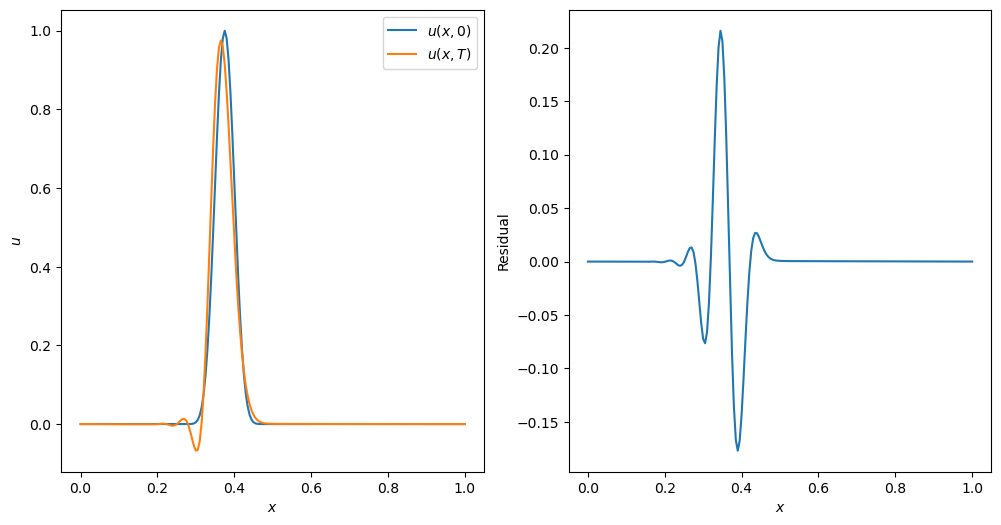

In [2]:
def zeta(x, t):
    c = 1.0
    return 4.0 * (x - c * t) - 1.0

def compute_u(x, t):
    sln = 4 * zeta(x, t) * (1.0 - zeta(x, t))
    return np.maximum(np.zeros(sln.shape), sln) ** 12



# Grid Stuff
Lx = 1
nx = 201
ny = 201

x = np.linspace(0, Lx, nx)
dx = Lx / (nx - 1)

grid = Grid(shape=(nx), extent=(Lx))

# Initialise field
init_u = Function(name="init_u", grid=grid)
init_u.data[:] = compute_u(x, 0)

t = grid.stepping_dim
time = grid.time_dim


u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)
dt = 0.001
# Give first two data points
u.data[0, :] = init_u.data[:]
u.data[1,:] = compute_u(x,dt)

# Create equation and boundary conditions
pde = u.dt2 - u.dx2
eq = Eq(u.forward, solve(pde, u.forward))
bc1 = Eq(u[t + 1, 0], 0.)
bc2 = Eq(u[t + 1, nx - 1], 0.)

op = Operator([eq, bc1, bc2])
op.apply(time_m=1, time_M=1999, dt=dt)

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
ax0.plot(x, init_u.data[:], label = "$u(x,0)$")
ax0.plot(x, u.data[0, :], label = "$u(x,T)$")
ax0.set_xlabel('$x$')
ax0.set_ylabel('$u$')
ax0.legend()

# Calculate residual
ax1 = fig.add_subplot(122)
ax1.plot(x, (u.data[0, :] - init_u.data[:]), label='Residual')
ax1.set_xlabel('$x$')
ax1.set_ylabel('Residual')
ax1.legend


#### **Hint** regarding boundary conditions:

Dirichlet boundary conditions can be set via a list of equation as, e.g., `bc=[Eq(u[t+1, 0], 0)]` and then included in an operator via `op=Operator([main_list_of_equations]+bc)`. See the linear convection example from the first notebook of lecture 10.

## Excersie 2: Comparison against exact solution 2

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="figures/exact_solution.png" width="450" height="450" align="center"/>

- **Show that the exact solution to this problem is:**
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

Below is a snippet of code to plot the exact result at any point in time. You can use it to explore the evolution of the wave. Does it produce the expected behavior?

Operator `Kernel` ran in 0.01 s


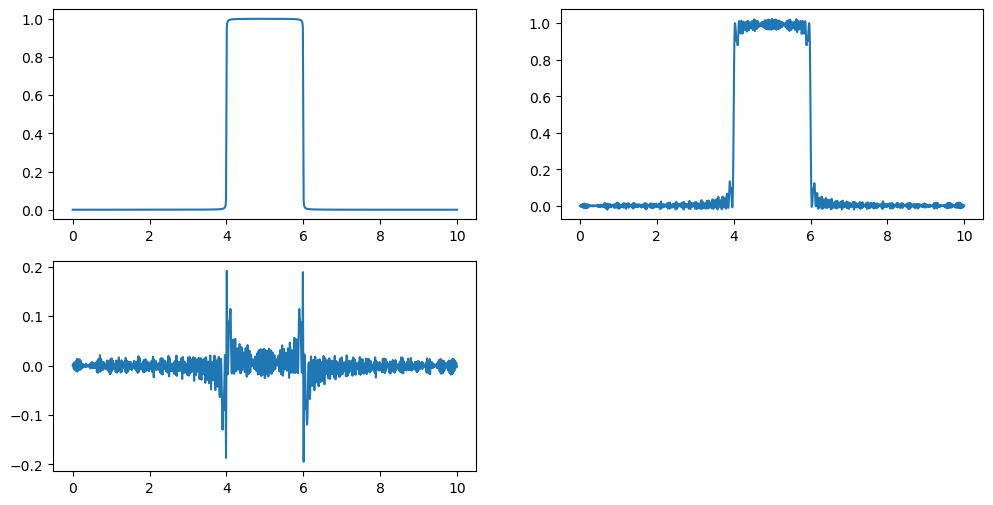

In [3]:
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = np.linspace(0, L, l)

def A_n(n):
    lhs = (2.) / (n * np.pi)
    rhs = np.cos((4. * n * np.pi) / (L)) - np.cos((6. * n * np.pi) / (L))
    return lhs * rhs

def compute_u(x, t):
    s = np.zeros(x.size)
    for n in range(1, N + 1):
        s += A_n(n) * np.sin((n * np.pi * x) / (L)) * np.cos((n * np.pi * c * t) / (L))
    return s

# Plot exact
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(221)
T = 0
ax0.plot(x, compute_u(x, T))

# Devito

## Grid
grid = Grid(shape=l, extent=L)
t = grid.stepping_dim
time = grid.time_dim

## Function
u = TimeFunction(name='u', grid=grid, space_order=4, time_order=2)
dx = abs(x[1] - x[0])
dt = 0.004

u_0 = compute_u(x, 0)
u_1 = compute_u(x, dt)
u.data[0, :] = u_0
u.data[1, :] = u_1

## Equations
pde = (1/ c**2) * u.dt2 - u.dx2
eq = Eq(u.forward, solve(pde, u.forward))
bc1 = Eq(u[t + 1, 0], 0.)
bc2 = Eq(u[t + 1, N - 1], 0.)

## Operator
op = Operator([eq, bc1, bc2])
op.apply(time_m=1, time_M=int(20 / dt), dt=dt)

ax1 = fig.add_subplot(222)
ax1.plot(x, u.data[-1, :])

ax2 = fig.add_subplot(223)
ax2.plot(x, (compute_u(x, T) - u.data[-1, :]))



- **Can you write a finite difference code to solve the above problem?**
- **Can you now also solve the same problem using Devito?**
- **How similar is your solution to the exact solution? How do you think this result can be improved?**